# Predict the value of football players

Can we predict the value of a football player, given their playing attributes and a few additional features?

Which players are over/undervalued compared to the market?

As a young player, which are the skills/positions which are most in demand?


## Imports

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from const import ATTRIBUTES

## Load data

Load the processed clean dataset. Remove the columns for name/link/id etc. and keep columns with predictive data. For this exercise we will not use the players' wages as a feature as it is directly correlated with 'value', therefore if you know the wage of the player it is not difficult to estimate the wage. It is more useful to just use playing attributes (along with age and position) to assess the value of the player as that will enable us to draw inferences about which playing attributes are perceived as more valuable.

In [2]:
raw_df = pd.read_csv("data/1. processed/data_clean.csv")

df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

#select sensible features
df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()
df.shape

(13758, 39)

### Missing data

Crossing             0
Finishing            0
Heading Accuracy     0
Short Passing        0
Volleys              0
Dribbling            0
Curve                0
FK Accuracy          0
Long Passing         0
Ball Control         0
Acceleration         0
Sprint Speed         0
Agility              0
Reactions            0
Balance              0
Shot Power           0
Jumping              0
Stamina              0
Strength             0
Long Shots           0
Aggression           0
Interceptions        0
Positioning          0
Vision               0
Penalties            0
Composure            0
Marking              0
Standing Tackle      0
Sliding Tackle       0
GK Diving            0
GK Handling          0
GK Kicking           0
GK Positioning       0
GK Reflexes          0
age                  0
overall_rating       0
potential            0
Position            39
value_clean          0
dtype: int64

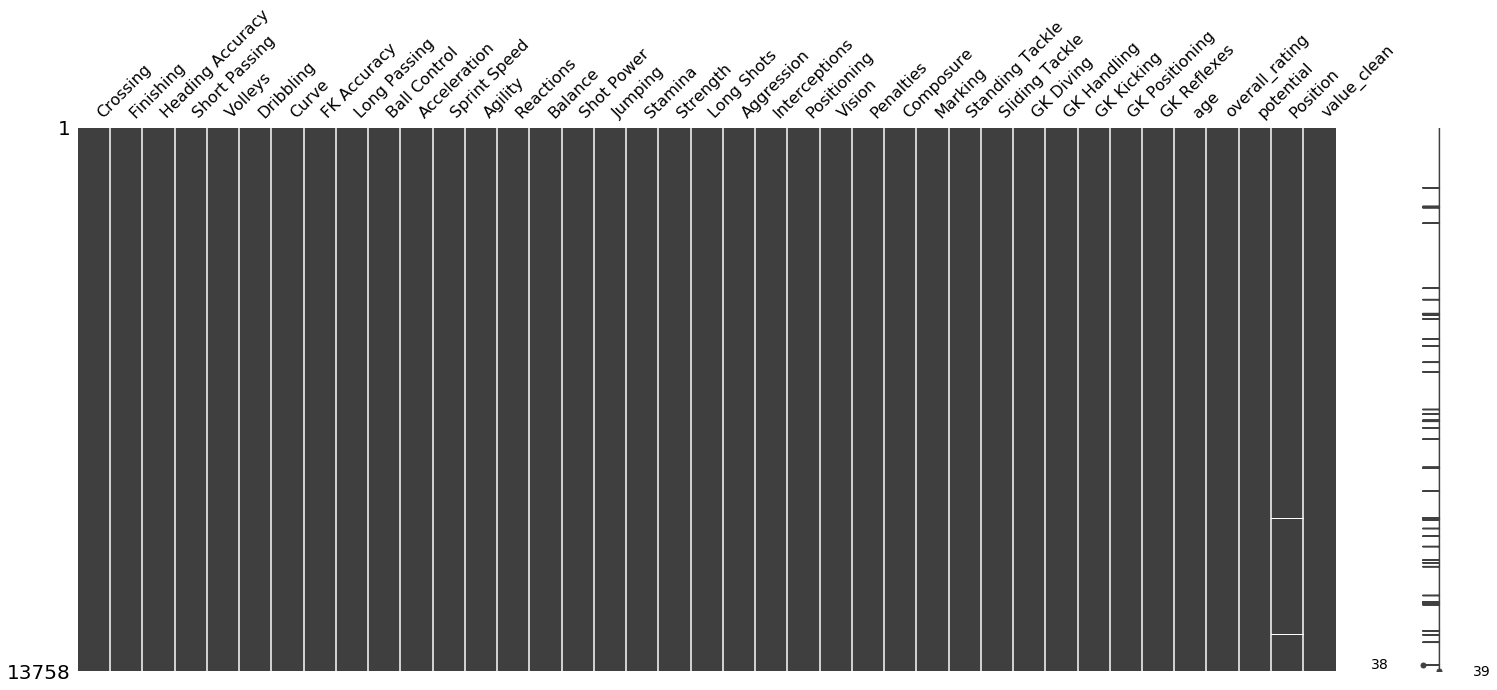

In [3]:
display(df.isnull().sum())

msno.matrix(df)
plt.show()

The position data has 39 missing datapoints. As this is only a very small subset of the data I will drop these datapoints

In [4]:
#drop missing datapoints
df = df.loc[df['Position'].notnull()].copy()

## EDA

Before modelling we will carry out some exploratory data analysis to get an idea of the features of the data.

**Target variable - 'value_clean'**

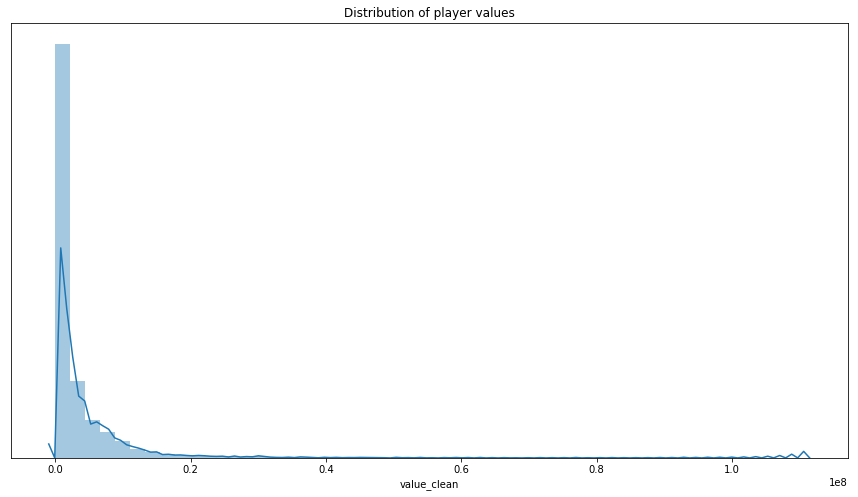

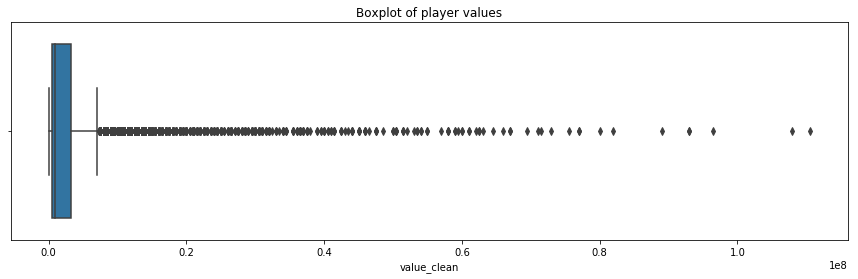

count    1.371900e+04
mean     3.163104e+06
std      6.367481e+06
min      1.000000e+04
25%      4.750000e+05
50%      9.500000e+05
75%      3.200000e+06
max      1.105000e+08
Name: value_clean, dtype: float64

In [5]:
def plot_distribution_and_stats(feature,name):
    plt.figure(figsize=(15,8))
    sns.distplot(feature)
    plt.title(f"Distribution of {name}")
    plt.yticks([])
    plt.show()

    
    plt.figure(figsize=(15,4))
    sns.boxplot(feature)
    plt.title(f"Boxplot of {name}")
    plt.show()
    
    display(feature.describe())
    
plot_distribution_and_stats(df['value_clean'],'player values')

The player value is our target feature. As might be expected the value of players varies significantly. The distribution shows that the variable is very positively skewed which could make prediction of very high value players difficult. 

The highest value player is &euro;110M and the lowest value player is just &euro;10,000. The mean is approximately &euro;3M but with a very large standard deviation of &euro;6M.

Due to these unfavorable distribution statistics, it will be a good idea to apply a log transformation on the data to reduce the variance in the target variable.

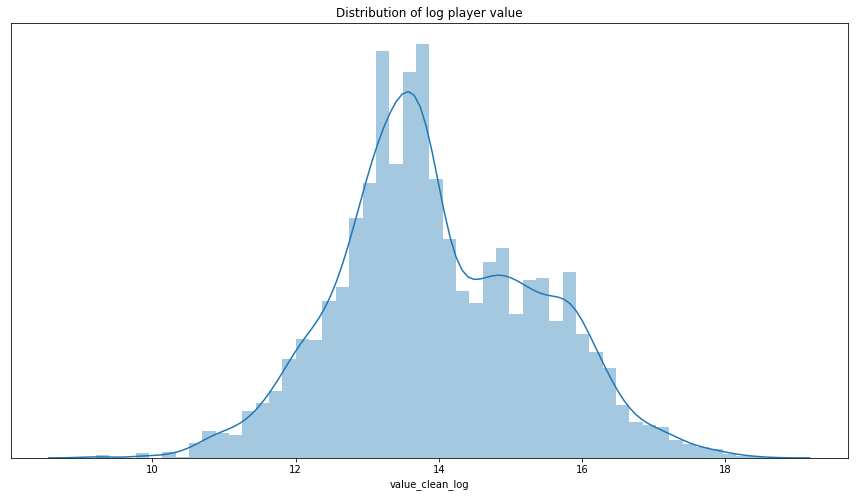

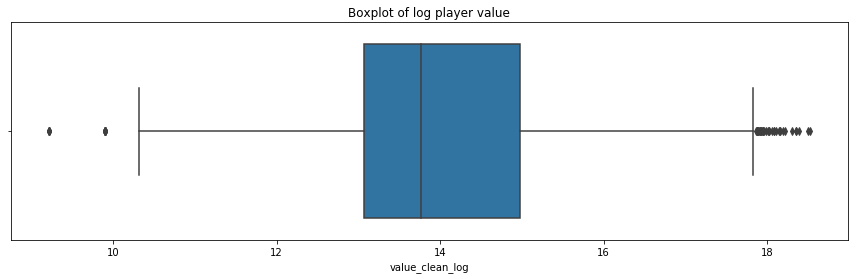

count    13719.000000
mean        13.974646
std          1.387843
min          9.210340
25%         13.071070
50%         13.764217
75%         14.978661
max         18.520526
Name: value_clean_log, dtype: float64

In [6]:
df['value_clean_log'] = np.log(df['value_clean'])

plot_distribution_and_stats(df['value_clean_log'],'log player value')

The target variable now looks more normally distributed and has a much lower standard deviation compared to the mean.

The box plot shows that most of the data is within the interquartile range with a few outliers at the top and bottom ends. We might need to drop these datapoints during training the model.

### Feature analysis

**Age Feature**

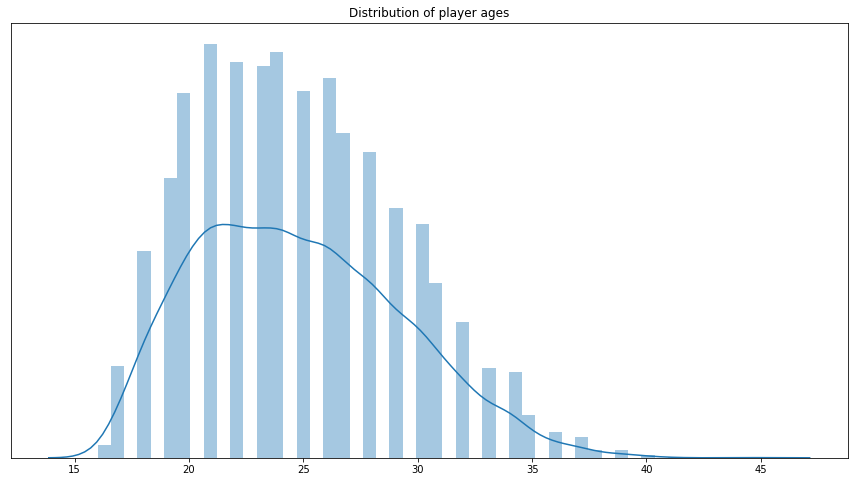

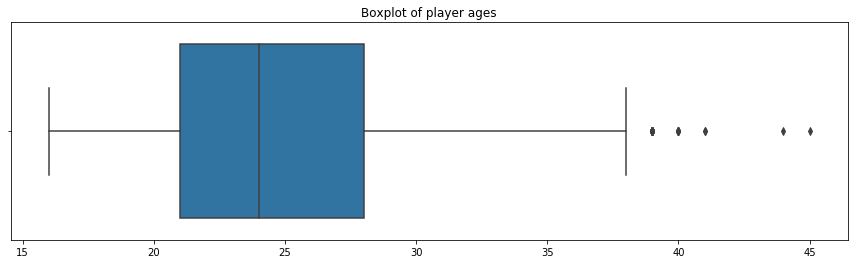

,age
count,13719.000000
mean,24.803120
std,4.516523
min,16.000000
25%,21.000000
50%,24.000000
75%,28.000000
max,45.000000


In [7]:
plot_distribution_and_stats(df[['age']],'player ages')

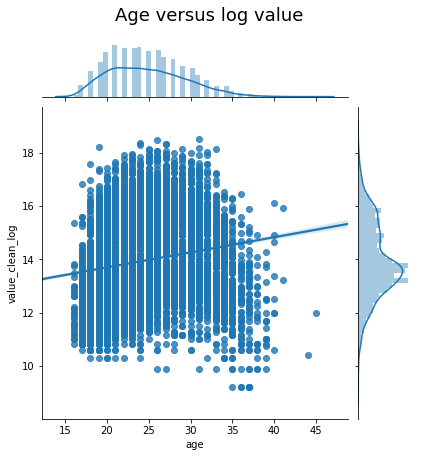

Pearson correlation = 0.18421933332162066


In [8]:
sns.jointplot(x='age',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Age versus log value",fontsize=18,y=1.05)
plt.show()

from scipy.stats import pearsonr
print(f"Pearson correlation = {pearsonr(df['value_clean_log'],df['age'])[0]}")

There seems to be a slight positive correlation between age and value, however, there is a lot of variance in the residuals.

**Player position**

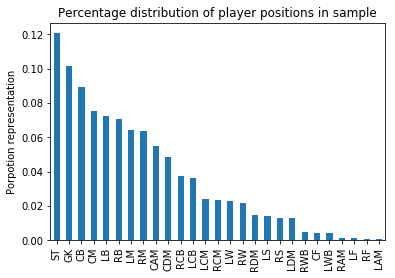

Number of unique positions = 27


In [9]:
df['Position'].value_counts(normalize=True).plot(kind='bar')
plt.title("Percentage distribution of player positions in sample")
plt.ylabel("Porpotion representation")
plt.show()

print(f"Number of unique positions = {df['Position'].nunique()}")

Position is the only categorical feature in the data.

Interestingly, striker is the most prevalent position in the dataset followed by goalkeepers.

There are 27 unique positions. This is quite a lot for a categorical variable and it may be sensible to bucket these positions into more general categories (e.g. attacker, midfielder, defender etc..). I will create a new feature for these buckets.

In [10]:
def bucket_positions(pos):

    positions_dict = {
        'attack': ['CF', 'RF', 'LF', 'ST', 'LS', 'RS'],
        'midfield': ['CM', 'CAM', 'RM', 'CDM', 'LM', 'RCM', 'LCM', 'RDM', 'LDM', 'RAM', 'LAM', 'LW', 'RW'],
        'defence': ['LCB', 'CB', 'RB', 'RCB', 'LWB', 'LB', 'RWB'],
        'goal_keeper': ['GK']}

    for category, pos_list in positions_dict.items():
        if pos in pos_list:
            return category
    
    return np.nan

In [11]:
df['Position_bucket'] = df['Position'].apply(bucket_positions)

del df['Position']

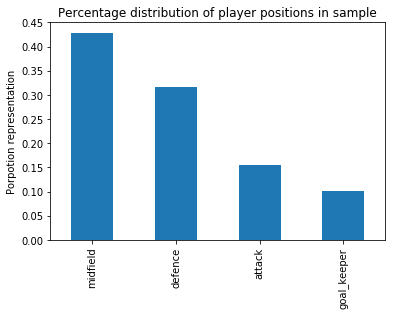

In [12]:
df['Position_bucket'].value_counts(normalize=True).plot(kind='bar')
plt.title("Percentage distribution of player positions in sample")
plt.ylabel("Porpotion representation")
plt.show()


This new feature is reduced to just four different categories.

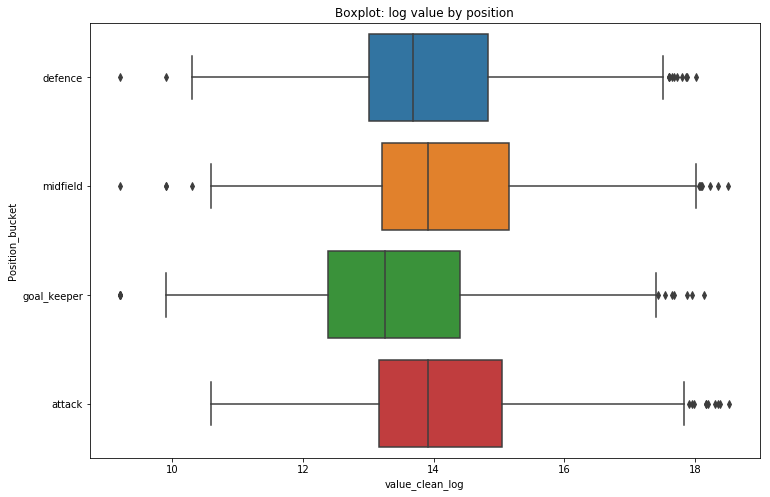

In [13]:
plt.figure(figsize=(12,8))
sns.boxplot(x='value_clean_log',y='Position_bucket',data=df)
plt.title("Boxplot: log value by position")
plt.show()

The distributions show that the distributions of log value are similar for each position category. Goal keepers tnd to have lower values on average and attackers tend to have higher 'value' which would be expected. Attackers have more outliers at the higher end of their distribution.

**Player attribute features**


In [14]:
print(F"There are {len(ATTRIBUTES)} different player attributes")
ATTRIBUTES

There are 34 different player attributes


['Crossing',
 'Finishing',
 'Heading Accuracy',
 'Short Passing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long Passing',
 'Ball Control',
 'Acceleration',
 'Sprint Speed',
 'Agility',
 'Reactions',
 'Balance',
 'Shot Power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long Shots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'Standing Tackle',
 'Sliding Tackle',
 'GK Diving',
 'GK Handling',
 'GK Kicking',
 'GK Positioning',
 'GK Reflexes']

I would assume that a lot of these features will be highly correlated with each other (e.g. Goal keeping attributes will be negatively correlated with attacking attributes such as shooting, dribbling etc.), there could be scope to reduce the number of these features if necessary to improve the model.

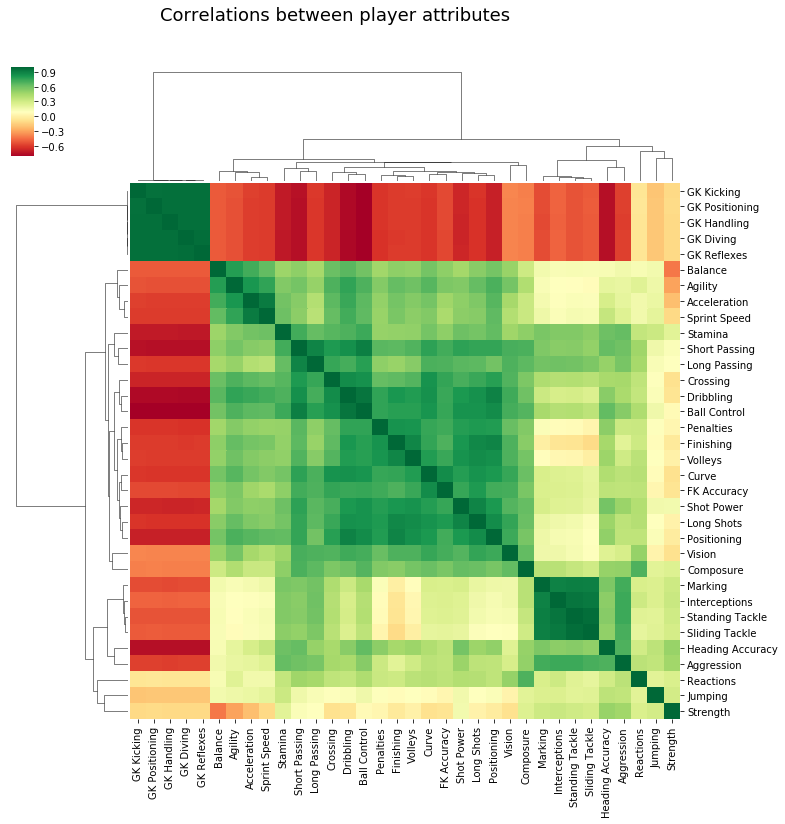

In [15]:
sns.clustermap(df[ATTRIBUTES].corr(),cmap='RdYlGn',figsize=(12,12))
plt.suptitle("Correlations between player attributes",fontsize=18,y=0.95)
plt.show()

There are a number of highly correlated features, it may be necessary to reduce some of these features for modelling.

**Player potential**

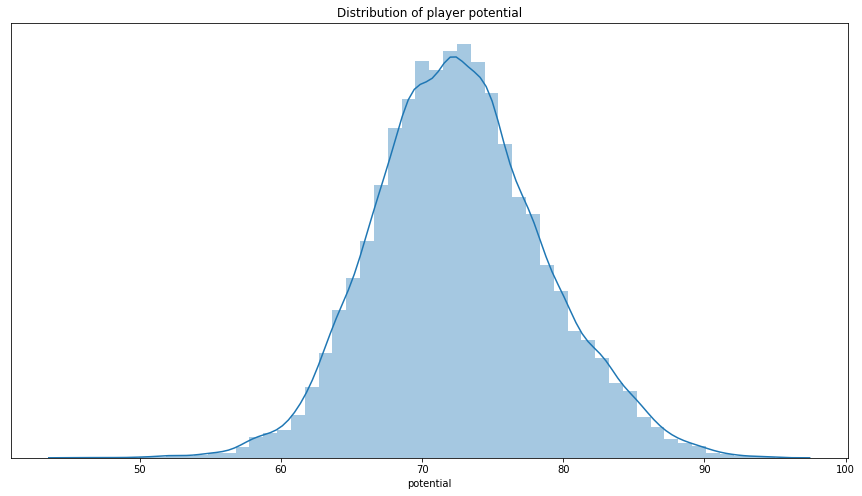

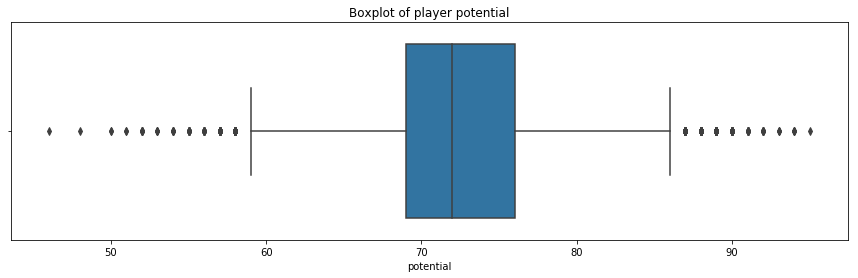

count    13719.000000
mean        72.657482
std          6.027961
min         46.000000
25%         69.000000
50%         72.000000
75%         76.000000
max         95.000000
Name: potential, dtype: float64

In [16]:
plot_distribution_and_stats(df['potential'],'player potential')

Player potential is pretty much normally distributed with a mean of 72.

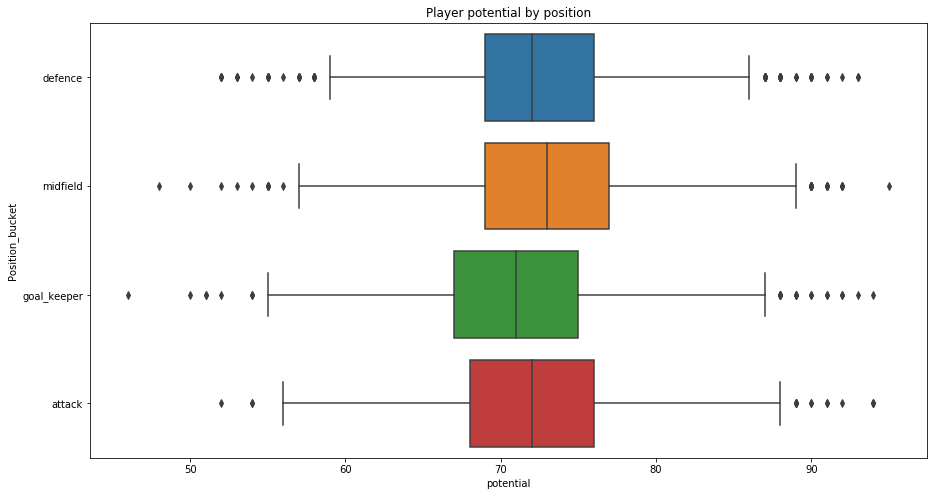

In [17]:
plt.figure(figsize=(15,8))
sns.boxplot(x='potential',y='Position_bucket',data=df)
plt.title("Player potential by position")
plt.show()

The player potential does not seem to be materially different for the different positions.

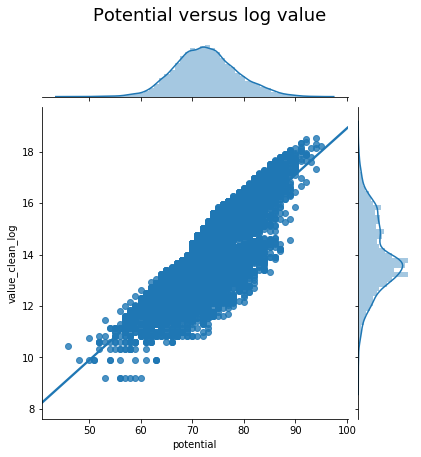

In [18]:
sns.jointplot(x='potential',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Potential versus log value",fontsize=18,y=1.05)
plt.show()

There is a strong positive correlation between potential and log value.

Player potential and overall rating a probably very correlated, to check this we can plot potential versus overall rating.

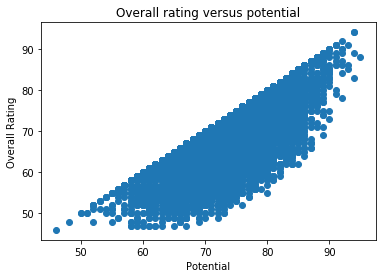

Pearson correlation = 0.6660520899052275


In [19]:
plt.scatter(x=df['potential'],y=df['overall_rating'])
plt.xlabel("Potential")
plt.ylabel("Overall Rating")
plt.title("Overall rating versus potential")
plt.show()

print(f"Pearson correlation = {pearsonr(df['potential'],df['overall_rating'])[0]}")

We can see that the overall rating is lower than the player potential, which makes sense. However, the correlation is only 0.66, therefore it is probably useful to keep both features for modelling.

Another feature that could be of interest is the difference between the current player rating and the player potential. I will create this feature and call it 'potential_growth'. Players with higher growth potential may be of lower value currently.

In [20]:
#create new feature
df['potential_growth'] = df['potential']-df['overall_rating']

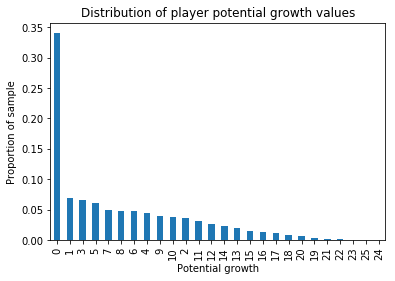

In [21]:
df['potential_growth'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribution of player potential growth values")
plt.ylabel("Proportion of sample")
plt.xlabel("Potential growth")
plt.show()

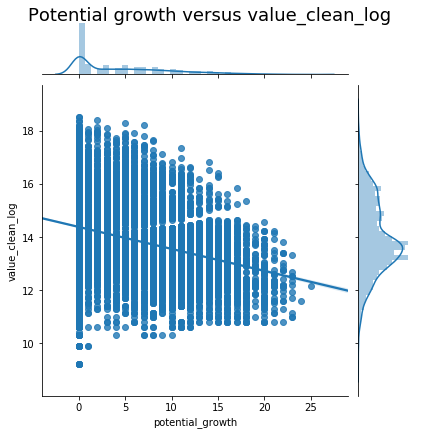

Pearson correlation = -0.31245629202124825


In [22]:
sns.jointplot(x='potential_growth',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Potential growth versus value_clean_log",fontsize=18,y=1)
plt.show()

print(f"Pearson correlation = {pearsonr(df['value_clean_log'],df['potential_growth'])[0]}")


Interestingly, the potential growth is negatively correlated with the log value which tells us that the higher the potential growth, the lower the current player value is. However, this does not really tell you much as players with lower overall ratings almost by definition have more scope to improve and therefore have higher growth potential compared to players which are already rated highly.

I don't think this feature will add any additional value to the model.

In [ ]:
del df['potential_growth']

**Player overall rating**

In [ ]:
plot_distribution_and_stats(df['overall_rating'],'overall rating')

Overall rating is normally distributed with a average of 68, min of 46 and max of 94. The distribution has long tails on both sides with low and high outliers.

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x='overall_rating',y='Position_bucket',data=df)
plt.title("Boxplot: position versus overall rating")
plt.show()

The overall ratings for each player position are very similar. Interestingly, this is in contrast to the boxplot of player position versus log value, where attackers had a higher value. This suggests that attackers come at a premium compared to their overall rating.

In [ ]:
sns.jointplot(df['overall_rating'],
              df['value_clean_log'],
              kind="reg")

print(f"R2 = {pearsonr(df['overall_rating'],df['value_clean_log'])[0]**2}")


Overall rating is highly correlated with log value with an R2 of 0.89.

### EDA summary

In [ ]:
#correlation between each feature and the target variable (value_clean_log)
df.corr()['value_clean_log'].sort_values()

**- The target variable, value, has been log transformed to deal with extremely high value players**  
**- Player position has been converted into 'buckets' of more general positions (GK, defender, midfield, attacker)**  
**- Some playing attributes are very correlated with each other. It may be necessary to combine/drop some of these features**  
**-attacking players are valued at a premium to other players of the same overall rating**   


## Data Preparation

- train/test split
- create pipeline for feature generation from original dataframe
- feature scaling
- create dummy variables for categorical features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#load in raw data again
def make_data_set():
    
    #load raw data
    raw_df = pd.read_csv("data/1. processed/data_clean.csv")    
    df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

    #select sensible features
    df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()
    
    #log transform value_clean attribute
    df['target'] = np.log(df['value_clean'])
    del df['value_clean']
    
    
    #drop missing position datapoints
    df = df.loc[df['Position'].notnull()].copy()
    
    #create player position buckets
    df['Position_bucket'] = df['Position'].apply(bucket_positions) 
    del df['Position']
    
    #reorder columns to have target variable at the end
    df = df[list(df.columns[:-2]) + ['Position_bucket','target']]
    
    #make sure no missing data
    assert df.isnull().sum().sum() == 0
    
    #shuffle the datafrmae
    df_shuffled = shuffle(df, random_state=0)

    #create train and test split
    return train_test_split(df_shuffled.iloc[:,:-1],
                            df_shuffled.iloc[:,-1],
                            test_size=0.33,
                            random_state=0)
    
    

I will use sklearn Pipelines to make sure the methodology is robust and avoid accidental data leakage

In [ ]:
X_train, X_test, y_train, y_test = make_data_set()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())])

nominal_categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder())])


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns


#apply transformations to numerical and categroical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', nominal_categorical_transformer, categorical_features)])

## Baseline model

Now that we have the preprocessing pipeline we need to define the metric that we want to optimise for and define a 'naive' model to benchmark the results of the machine learning model.

From the EDA section we discovered that overall rating had the highest correlation with the value of the player (0.94). Therefore the simplest model with good performance is likely to be a simple regression of overall rating versus log value.

We will optimise for RSME because we want to be able to predict the value of a player, in particular the players which are significantly under of over valued. Therefore we want to choose a metric which penalises predicts which are very far away from the truth. RMSE is given by the following equation:


$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{e^2}}$$

Where $e$ is the error (difference between predicted and actual).  

As this is a squared term, large errors will be amplified and increase the RSME and lead to a worse performance of the model.

In [ ]:
model_accuracies = pd.DataFrame(columns=['model','RMSE'])

def add_model_accuracy(name,RMSE,model_accuracies):
    if name not in model_accuracies['model'].values:
        model_accuracies = model_accuracies.append({'model':name,'RMSE':RMSE},ignore_index=True)
        
        return model_accuracies
    else:
        return model_accuracies
    

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x = X_train['overall_rating'].values.reshape(-1,1)
y = y_train.values.reshape(-1,1)

baseline_reg_model = LinearRegression()
baseline_reg_model.fit(x,y)

baseline_pred = baseline_reg_model.predict(X_test['overall_rating'].values.reshape(-1,1))

baseline_RMSE = np.sqrt(mean_squared_error(y_test, baseline_pred))

model_accuracies = add_model_accuracy(name='baseline lin reg',RMSE=baseline_RMSE,model_accuracies=model_accuracies)

model_accuracies

## Multiple Linear Regression

Before attempting any 'fancy' ML methods, we can try a traditional stats approach to this problem using multiple linear regression.

In [ ]:
#create dummy variables for multiple linear regression 
X_train_mlr = pd.get_dummies(X_train,drop_first=True)
X_test_mlr = pd.get_dummies(X_test,drop_first=True)

In [ ]:
import statsmodels.api as sm

mlr = sm.OLS(y_train,X_train_mlr).fit()

mlr_pred = mlr.predict(X_test_mlr)

mlr_RMSE = np.sqrt(mean_squared_error(y_test, mlr_pred))

plt.figure(figsize=(12,12))
mlr.params.sort_values().plot(kind='barh')
plt.title("Feautre importance - multiple linear regression")
plt.show()

In [ ]:
model_accuracies = add_model_accuracy(name='mlr',RMSE=mlr_RMSE,model_accuracies=model_accuracies)
model_accuracies

### Backward elimination

Reduce the number of features by 

In [ ]:
#Backward Elimination
cols = list(X_train_mlr.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train_mlr[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

In [ ]:
mlr_be = sm.OLS(
    y_train, X_train_mlr[selected_features_BE]).fit()

mlr_be_pred = mlr_selected_features.predict(
    X_test_mlr[selected_features_BE])

mlr_be_RMSE = np.sqrt(
    mean_squared_error(y_test, mlr_be_pred))


In [ ]:
mlr_back_elim.params.sort_values().plot(kind='barh')
plt.title("Feautre importance - multiple linear regression (back elimination)")
plt.show()

In [ ]:
model_accuracies = add_model_accuracy(name='mlr_be',RMSE=mlr_back_elim_RMSE,model_accuracies=model_accuracies)
model_accuracies

## Dealing with outliers - need to do this after train-test split

In [ ]:
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data,CUT_OFF=3):
    
    anomalies = []
    
    data_std, data_mean = np.std(data), np.mean(data)
    anomaly_cut_off = data_std * CUT_OFF
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

anomalies = find_anomalies(df['value_clean_log'])

anomolies_index = df.loc[df['value_clean_log'].isin(anomalies)].index
print("Players with log values outside 3 std")
raw_df.iloc[anomolies_index][['name']]

There are only 18 players with values outside three std of the mean. I will drop these from the data.

In [ ]:
#drop original target variable 'value_clean' 
df.drop(columns=['value_clean'])

df.shape

__Outlier detection__

calculate Cook's distances for linear regression [link](http://mpastell.com/2013/04/19/python_regression/)

## Future Work

Get data from different timeperiods e.g. from 5 years ago and now to create a model which predicts the value of the player (or percentage increase in value) in 5 years time.